# TSL Timing Screen Screenshot and Data Grabber

This originally started out as a simple script to grab a screenshot of a TSL Timing screen. IT then got a little bit more complicated as I added in a routine that tried to email the screenshot to one or more recipients, and then way more complicated as I started to actually scrape data from the timing screen on the one hand, and ustomate the collection of scrapes, grabbing of screenshots, and mailing of all sorts of things on the other.

The plan now is to turn this into a proper development narrative to try to recreate, in idealised form, how the various puzzle pieces were identified, solved and pieced together...

...as well as tidying up the code, making a simple CLI for it, and packaging it so that it can be easily deployed to collect data whenever, as wheresoever, it's required.

*Note that the original recipe is easily generalised to grab arbitrary webpages.*

In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
#Inspired by: https://www.kaggle.com/dierickx3/kaggle-web-scraping-via-headless-firefox-selenium
#from webdriverdownloader import GeckoDriverDownloader
#gdd = GeckoDriverDownloader()
#geckodriver, geckobin = gdd.download_and_install("v0.23.0")

#Alternatively, we can install as part of the container build process

In [12]:
%matplotlib inline

## Set up a browser instance

We can create a headless browser (one that doesn't need to open in a window that we can see) that we can load pages into and grab screenshots from. As we are running an actual browser, if the web page is being updated via a websocket connection, our remotely launched browser will be being updated with the socket connection data.

So once we launch our browser onto a timing screen, we can just keep referencing the browser to get the latest view of the page...

In [13]:
from selenium import webdriver
from selenium.webdriver.firefox.options import Options

options = Options()
options.headless = True

#If we need to set the path to geck, we can...
#browser = webdriver.Firefox(executable_path=geckobin, options=options)

browser = webdriver.Firefox(options=options)

Set the URL of the page you want to grab the screenshot for:

In [14]:
url = "https://livetiming.tsl-timing.com/191231"
url = 'https://livetiming.tsl-timing.com/191209'
url = 'https://livetiming.tsl-timing.com/191431'#brscc april 6
#url='https://livetiming.tsl-timing.com/191403' #btcc april 6
url='https://livetiming.tsl-timing.com/191521' #croft barc april 13
url='https://livetiming.tsl-timing.com/191851' #donington historic

Some web pages take time to load. For example, the TSL live timing screens are likely to show a spinny thing when a timing screen page is first loaded.

*The TSL timing screen works by loading a page container, then sets up a data connection via a web socket to retrieve the actual timing updates. If we are just grabbing a screenshot of the rendered timing screen, we need to make sure we wait long enough for the spinny thing to disappear and for the table to be rendered.*

In [15]:
#desiredId = 'tablebody' #The HTML id of a tag we want to be visible before we grab the page screenshot
undesiredId = 'loading' #The HTML tag of an element we want to be invisible before we grab the page screenshot

Set the name of the image file you want to save the screenshot to:

In [16]:
outfile = 'screenshot.png'

Now we can grab the screenshot:

In [17]:
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By

In [18]:
#Set a default screensize...
#There are other ways of setting up the browser so that we can grab the full browser view,
#even long pages that would typically require scrolling to see completely
browser.set_window_size(800, 400)
browser.get(url)

#EC.visibility_of_element_located
#EC.presence_of_element_located
#EC.invisibility_of_element_located

#Let's wait for the spinny thing to disappear...
element = WebDriverWait(browser, 10).until( EC.invisibility_of_element_located((By.ID, undesiredId)))

#Save the page
browser.save_screenshot( outfile )
print('screenshot saved to {}'.format(outfile))

screenshot saved to screenshot.png


Preview the captured page:

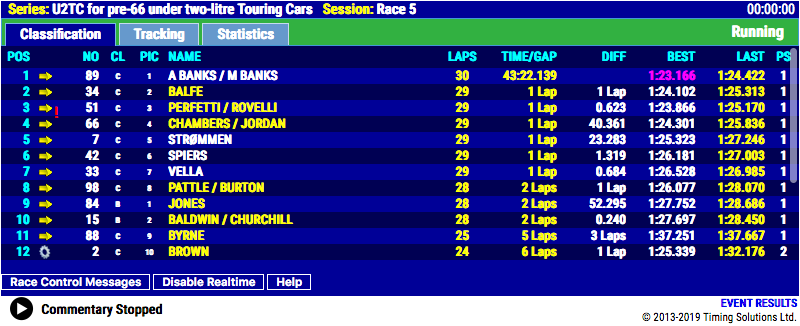

In [19]:
from IPython.display import Image
Image(outfile)

In [20]:
from selenium.common.exceptions import TimeoutException

#This will return something if it loads within the specified maxwait / timeout
def initBrowser(url, maxwait=10, maxtries=3):
    ''' Launch a new browser and '''
    browser = webdriver.Firefox(options=options)
    browser.get(url)
    
    try:
        element = WebDriverWait(browser, maxwait).until( EC.invisibility_of_element_located((By.ID, undesiredId)))
    except TimeoutException as e:
        browser.close()
        maxtries = maxtries-1
        if maxtries:
            #Try again with a longer wait, after a backoff
            time.sleep(maxwait)
            return initBrowser(url, maxwait*1.5, maxtries)
        
        return None

    return browser


#Note that we can also reload a page (ctrl-R) with:
#browser.refresh()

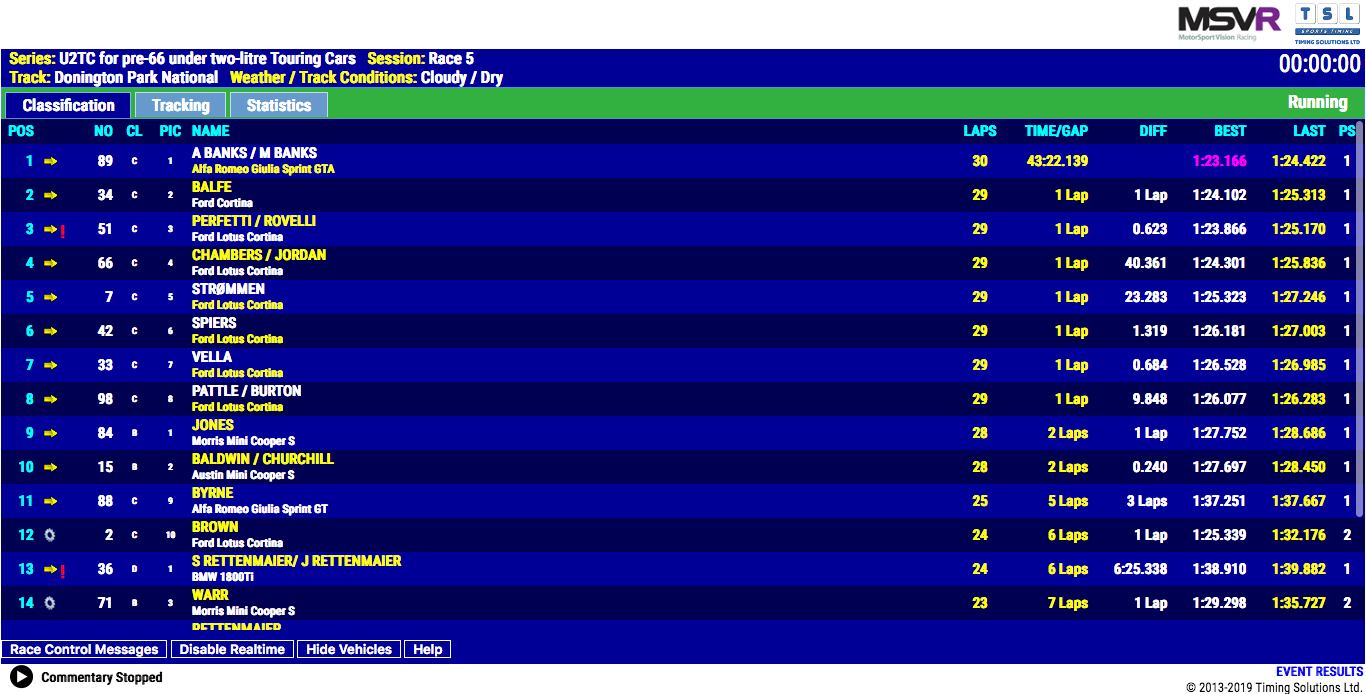

In [21]:
browser=initBrowser(url)
browser.save_screenshot( outfile )
Image(outfile)

## Tabs

- Classification: current ranking
- Tracking: track map
- Weather:
- Statistics: fastest laps etc

We can also grab other tabs...

screenshot saved to screenshot_Classification.png


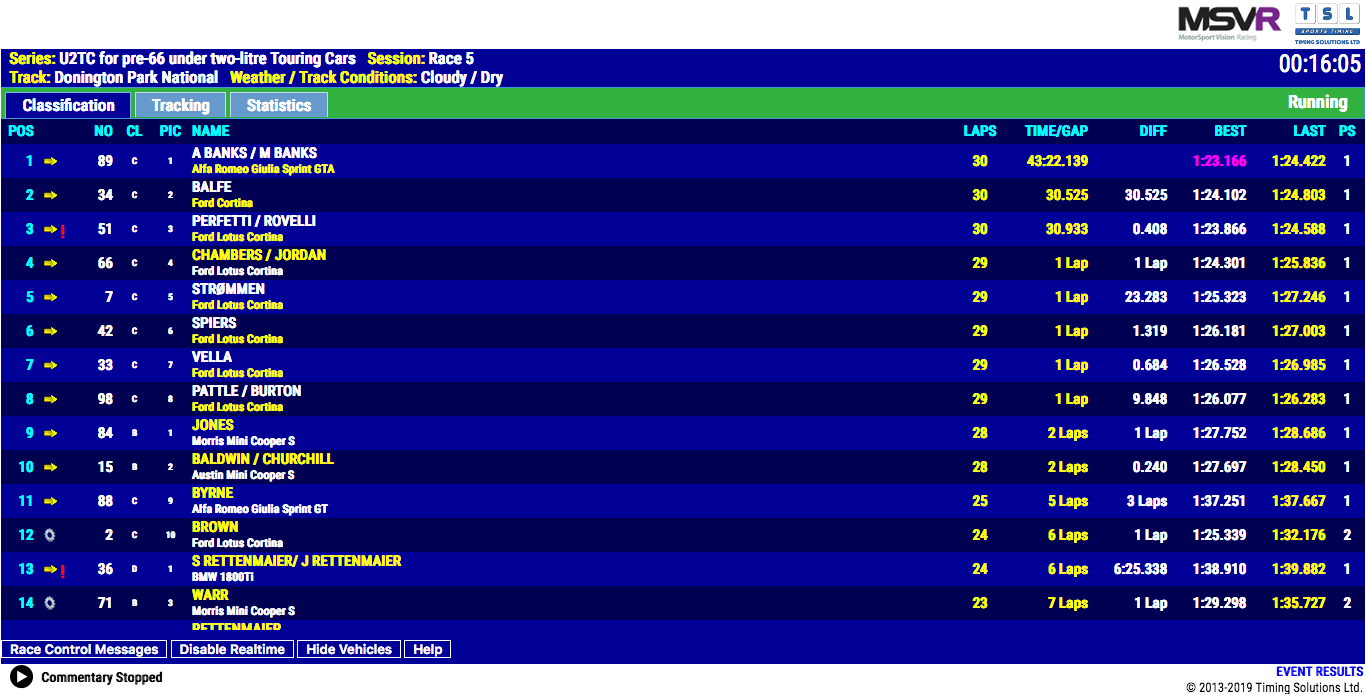

In [22]:
#Classification, Weather, Statistics

tabId = "Classification"
element = browser.find_element_by_id(tabId)
element.click()
element = WebDriverWait(browser, 10).until( EC.visibility_of_element_located((By.ID, tabId)))

ofn = '{}_{}.png'.format(outfile.replace('.png',''),tabId)

#Save the page
browser.save_screenshot( ofn )
print('screenshot saved to {}'.format(ofn))
Image(ofn)

### Grab some metadata

The timing screen includes information about the race series and the session the timing screen relates to. We can pull that data out of the timing screen to act as metadata.

In [23]:
#https://stackoverflow.com/a/12150013/454773
from selenium.common.exceptions import NoSuchElementException

def check_exists_by_xpath(driver, xpath):
    try:
        driver.find_element_by_xpath(xpath)
    except NoSuchElementException:
        return False
    return True

def text_value_from_xpath(driver, xpath):
    try:
        el = driver.find_element_by_xpath(xpath)
    except NoSuchElementException:
        return ''
    return el.text

#check_exists_by_xpath(browser, '//*[@id="currentflag"]')

In [24]:
#Let's use the classification screen as our "base" screen
tabId='Classification'
element = browser.find_element_by_id(tabId)
element.click()
element = WebDriverWait(browser, 10).until( EC.visibility_of_element_located((By.ID, tabId)))


Get the series name:

In [25]:
series_path='//*[@id="seriesName"]/span[2]'

series = text_value_from_xpath(browser, series_path)
series

'U2TC for pre-66 under two-litre Touring Cars'

And the session:

In [26]:
session_path = '//*[@id="sessionName"]/span[2]'
session = text_value_from_xpath(browser, session_path )
session

'Race 5'

We could use this information to give us meaningful filenames when we save timing screen images or data.

In [27]:
#Red flag
#//*[@id="currentflag"]
flag_path='//*[@id="currentflag"]'
flag = text_value_from_xpath(browser, flag_path )
flag

'Running'

In [28]:
sessionTime_path ='//*[@id="sessionTime"]'
sessionTime = text_value_from_xpath(browser, sessionTime_path )
sessionTime

'00:15:59'

In [98]:
import string
def tableNameCleaner(t):
    if t:
        t = t.replace(' - ','_').replace('-','_').replace(' ','_').translate(str.maketrans('','',string.punctuation.replace('_',''))).upper()
        t = t.replace('QUALIFYING','Q').replace('RACE','R').replace('CHAMPIONSHIP','')
    return t
    
def getInfo(browser):
    series_path='//*[@id="seriesName"]/span[2]'
    series = text_value_from_xpath(browser, series_path)
    
    session_path = '//*[@id="sessionName"]/span[2]'
    session = text_value_from_xpath(browser, session_path )

    return {'series':series,
            'session':session,
             'tablename': tableNameCleaner('{}_{}'.format(series,session)) }

In [30]:
 getInfo(browser)

{'series': 'U2TC for pre-66 under two-litre Touring Cars',
 'session': 'Race 5',
 'tablename': 'U2TC_FOR_PRE_66_UNDER_TWO_LITRE_TOURING_CARS_R_5'}

### Grabbing Images of the Timing Screen

We can create a simple function to use *selenium* to grab png screenshots of a particular tab on the timing screen.

In [124]:
def setPageTab(browser, tabId='Classification', ofn=None, preview=True, link=True):
    ''' Simple function to view a particular tab within a TSL timing screen. '''
    
    #Check the page has loaded
    element = WebDriverWait(browser, 10).until( EC.invisibility_of_element_located((By.ID, undesiredId)))
    
    #ofn is output filename
    element = browser.find_element_by_id(tabId)
    element.click()
    element = WebDriverWait(browser, 10).until( EC.visibility_of_element_located((By.ID, tabId)))

    ofn = ofn if ofn is not None else '{}_{}.png'.format(outfile.replace('.png',''),tabId)

    if preview or link:
        #Save the page
        browser.save_screenshot( ofn )
        print('screenshot saved to {}'.format(ofn))
        
        if preview:
            display(Image(ofn))

        if link:
            return ofn

In [32]:
#url = 'https://livetiming.tsl-timing.com/191209'
setPageTab(browser,'Classification', preview=False, link=True)

screenshot saved to screenshot_Classification.png


'screenshot_Classification.png'

We could create a meaningful filename from the series and session metadata. For example:

screenshot saved to U2TC for pre-66 under two-litre Touring Cars_Race 5.png


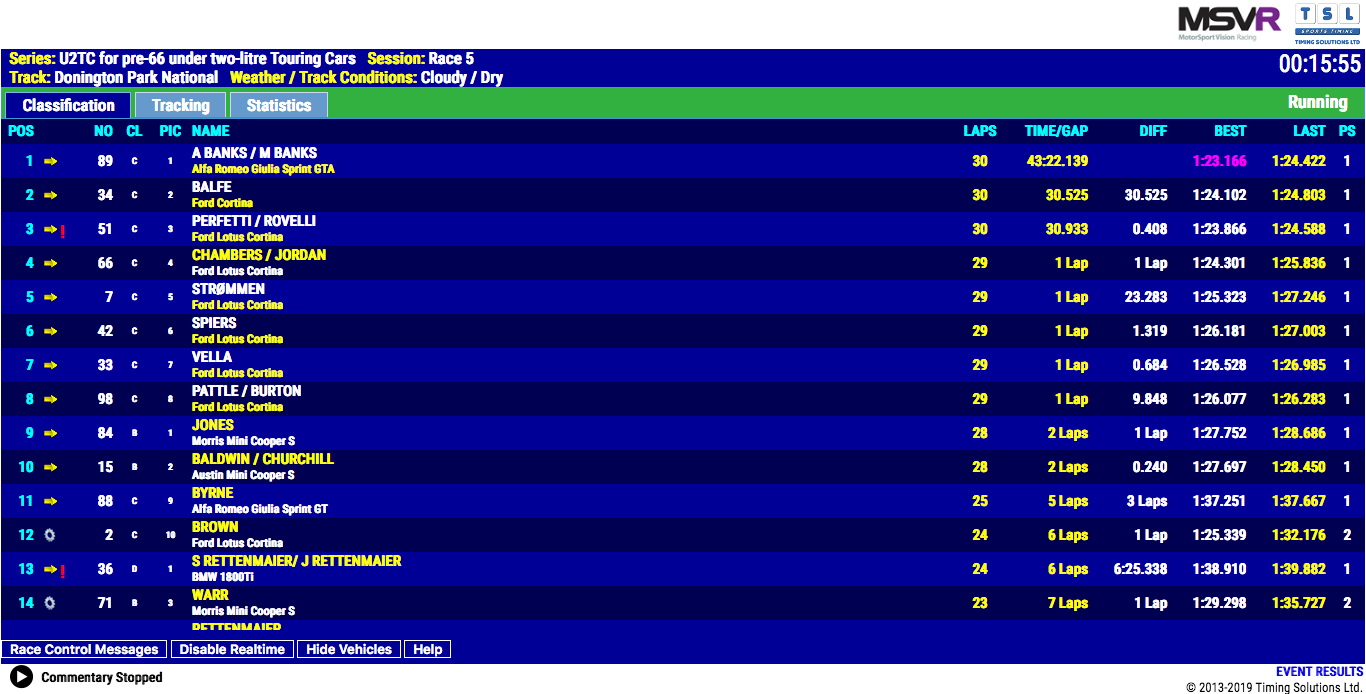

'U2TC for pre-66 under two-litre Touring Cars_Race 5.png'

In [33]:
#get file name
fn = '{}_{}.png'.format(series.replace('/','_'), session.replace('/','_') )

setPageTab(browser, 'Classification', fn)

We can get also access to the actual HTML via the element's `innerHTML()` attribute:

`el.get_attribute('innerHTML')`

If we grab the `<table>` element, this actually returns the contents contained *within* the table element, so we would need to recreate the outer `<table>` tag before we try to scrape the table data into a *pandas* dataframe. If we grab a `<div>` element that contains the table, we can scrape it directly into a *pandas* dataframe.

In [34]:
#classification data
xpath = '//*[@id="ResultsTableContainer"]'
el = browser.find_element_by_xpath(xpath)

In [35]:
import pandas as pd

df = pd.read_html( el.get_attribute('innerHTML'))[0].dropna(axis=1,how='all')
df.rename(columns={'Time/Gap':'TimeGap',
                   'Unnamed: 1':'Penalties'}, inplace=True)
df.head()

,Pos,Penalties,No,Cl,PIC,Name,Laps,TimeGap,Diff,Best,Last,PS
0,1,Penalties +0 seconds +0 position +0 lap +0...,89,C,1,A BANKS / M BANKS Alfa Romeo Giulia Sprint GTA,30,43:22.139,NaN,1:23.166,1:24.422,1
1,2,Penalties +0 seconds +0 position +0 lap +0...,34,C,2,BALFE Ford Cortina,30,30.525,30.525,1:24.102,1:24.803,1
2,3,Penalties +0.001 seconds +0 position +0 lap...,51,C,3,PERFETTI / ROVELLI Ford Lotus Cortina,30,30.933,0.408,1:23.866,1:24.588,1
3,4,Penalties +0 seconds +0 position +0 lap +0...,66,C,4,CHAMBERS / JORDAN Ford Lotus Cortina,29,1 Lap,1 Lap,1:24.301,1:25.836,1
4,5,Penalties +0 seconds +0 position +0 lap +0...,7,C,5,STRØMMEN Ford Lotus Cortina,29,1 Lap,23.283,1:25.323,1:27.246,1


In [36]:
df.dtypes

Pos           int64
Penalties    object
No            int64
Cl           object
PIC           int64
Name         object
Laps          int64
TimeGap      object
Diff         object
Best         object
Last         object
PS            int64
dtype: object

We also need to get the flag status. This is on path `//*[@id="tablebody"]/tbody/tr[3]/td[2]/div[1]`

In [37]:
browser=initBrowser(url)

In [38]:
els = browser.find_elements_by_xpath('//*[@id="tablebody"]/tbody/tr[*]/td[2]/div[1]')
for el in els:
    print(el.get_attribute("class").split(' ')[-1])

posIconBlank
posIconBlank
hasPenalties
posIconBlank
posIconBlank
posIconBlank
posIconBlank
posIconBlank
posIconBlank
posIconBlank
posIconBlank
hasPenalties
posIconBlank
posIconBlank
posIconBlank
posIconBlank
posIconBlank
posIconBlank


Let's make a function for that:

In [39]:
def getPosIcon(browser):
    els = browser.find_elements_by_xpath('//*[@id="tablebody"]/tbody/tr[*]/td[2]/div[1]')
    icons=[]
    for el in els:
        icons.append(el.get_attribute("class").split(' ')[-1])
    return pd.DataFrame({'icons':icons})

getPosIcon(browser)

,icons
0,posIconBlank
1,posIconBlank
2,hasPenalties
3,posIconBlank
4,posIconBlank
5,posIconBlank
6,posIconBlank
7,posIconBlank
8,posIconBlank
9,posIconBlank


In [40]:
df['icons'] = getPosIcon(browser)['icons']
df

,Pos,Penalties,No,Cl,PIC,Name,Laps,TimeGap,Diff,Best,Last,PS,icons
0,1,Penalties +0 seconds +0 position +0 lap +0...,89,C,1,A BANKS / M BANKS Alfa Romeo Giulia Sprint GTA,30,43:22.139,NaN,1:23.166,1:24.422,1,posIconBlank
1,2,Penalties +0 seconds +0 position +0 lap +0...,34,C,2,BALFE Ford Cortina,30,30.525,30.525,1:24.102,1:24.803,1,posIconBlank
2,3,Penalties +0.001 seconds +0 position +0 lap...,51,C,3,PERFETTI / ROVELLI Ford Lotus Cortina,30,30.933,0.408,1:23.866,1:24.588,1,hasPenalties
3,4,Penalties +0 seconds +0 position +0 lap +0...,66,C,4,CHAMBERS / JORDAN Ford Lotus Cortina,29,1 Lap,1 Lap,1:24.301,1:25.836,1,posIconBlank
4,5,Penalties +0 seconds +0 position +0 lap +0...,7,C,5,STRØMMEN Ford Lotus Cortina,29,1 Lap,23.283,1:25.323,1:27.246,1,posIconBlank
5,6,Penalties +0 seconds +0 position +0 lap +0...,42,C,6,SPIERS Ford Lotus Cortina,29,1 Lap,1.319,1:26.181,1:27.003,1,posIconBlank
6,7,Penalties +0 seconds +0 position +0 lap +0...,33,C,7,VELLA Ford Lotus Cortina,29,1 Lap,0.684,1:26.528,1:26.985,1,posIconBlank
7,8,Penalties +0 seconds +0 position +0 lap +0...,98,C,8,PATTLE / BURTON Ford Lotus Cortina,29,1 Lap,9.848,1:26.077,1:26.283,1,posIconBlank
8,9,Penalties +0 seconds +0 position +0 lap +0...,84,B,1,JONES Morris Mini Cooper S,28,2 Laps,1 Lap,1:27.752,1:28.686,1,posIconBlank
9,10,Penalties +0 seconds +0 position +0 lap +0...,15,B,2,BALDWIN / CHURCHILL Austin Mini Cooper S,28,2 Laps,0.240,1:27.697,1:28.450,1,posIconBlank


In [104]:
#Create this as a temporary table for a particular session
#Then think about merging into to a full table overal sessions / events etc

#The Flag is not within the table but can be captured to give a crude indication of flag conditions
#I wonder if I should also be capturing time of day somewhere as a crude record of sample times?
classification_table = '''
CREATE TABLE IF NOT EXISTS  "{_table}" (
  "Pos" INTEGER,
  "Penalties" TEXT,
  "Icons" TEXT,
  "No" INTEGER,
  "Cl" TEXT,
  "PIC" INTEGER,
  "Name" TEXT,
  "Laps" INTEGER,
  "Gap" TEXT,
  "Diff" TEXT,
  "Best" TEXT,
  "BestInS" FLOAT,  
  "Last" TEXT,
  "LastInS" FLOAT,
  "PS" FLOAT,
  "S1" TEXT,
  "V1" FLOAT,
  "S2" TEXT,
  "V2" FLOAT,
  "S3" TEXT, 
  "VF" FLOAT,
  "Flag" TEXT,
  PRIMARY KEY (No, Laps) ON CONFLICT IGNORE
);
'''
#PK WITH LAST, OR TIMEGAP??? Or just go with Number/Lap PK the first time we get that combination
#dan then ignore any updates to it?
#Rather that upsert, just do an insert, so we only get new Number/Laps combinations?

fastest_laps_table = '''
CREATE TABLE IF NOT EXISTS  "{_table}" (
    "NO" INTEGER,
    "NAME" TEXT,
    "TIME" TEXT,
    `TIME OF DAY` TEXT,
    "LAP" INTEGER,
    `AVG. SPEED (MPH)` FLOAT,
    "VEHICLE" TEXT
);
'''

flags_table = '''
CREATE TABLE IF NOT EXISTS  "{_table}" (
    "COLOUR" TEXT,
    `TOTAL TIME` TEXT,
    `TOTAL LAPS` INTEGER,
    "COUNT" INTEGER
);
'''

leaderhistory_table = '''
CREATE TABLE IF NOT EXISTS  "{_table}" (
    "NO" INTEGER,
    "NAME" TEXT,
    `FROM LAP` TEXT,
    `LAPS LED` INTEGER,
    `DISTANCE (MILES)` FLOAT,
    "VEHICLE" TEXT
);
'''

In [42]:
import sqlite3
from sqlite_utils import Database

dbname='may4test3.db'

#!rm $dbname
conn = sqlite3.connect(dbname, timeout=10)

_table = 'tsl_timing_classification'

#Setup database tables
c = conn.cursor()
c.executescript(classification_table.format(_table=_table))


DB = Database(conn)


If we grab the classification table with a period slightly less than that of the fastest sector time, and upsert on the table using the (car number, lap, gap) as a unique key, then we should make sure we capture all the laps and the sector times, though we will need to do a little bit of processing of the multiple rows captured for each driver for each lap. (As the timing screen is live, as the leader goes onto a new lap, every other driver goes at least 1 Lap behind; we have to recover from such things.)

The *(car number, lap, previous lap)* combination should also be unique. (I need to think, would that guarantee we capture section times?).

My original method used upserts to prevent collisions, but that's wrong, I think. SQLite lets us add a condition to the PK in a table definition that will ignore conflicts, so we can add a car number / lap combination to the tabe as soon as we see it, and then if we upload it again, perhaps with the `TimeGap` reset to `Lap 1` by the lead car starting a new lap, we can just ignore it.

In [47]:
url = 'https://livetiming.tsl-timing.com/191851'
browser = webdriver.Firefox(options=options)
browser.get(url)

#We need a delay after this or we may break the following by trying to look in the page for an element
#before it's had time to properly load and render
element = WebDriverWait(browser, 10).until( EC.invisibility_of_element_located((By.ID, undesiredId)))

screenshot saved to screenshot_Classification.png


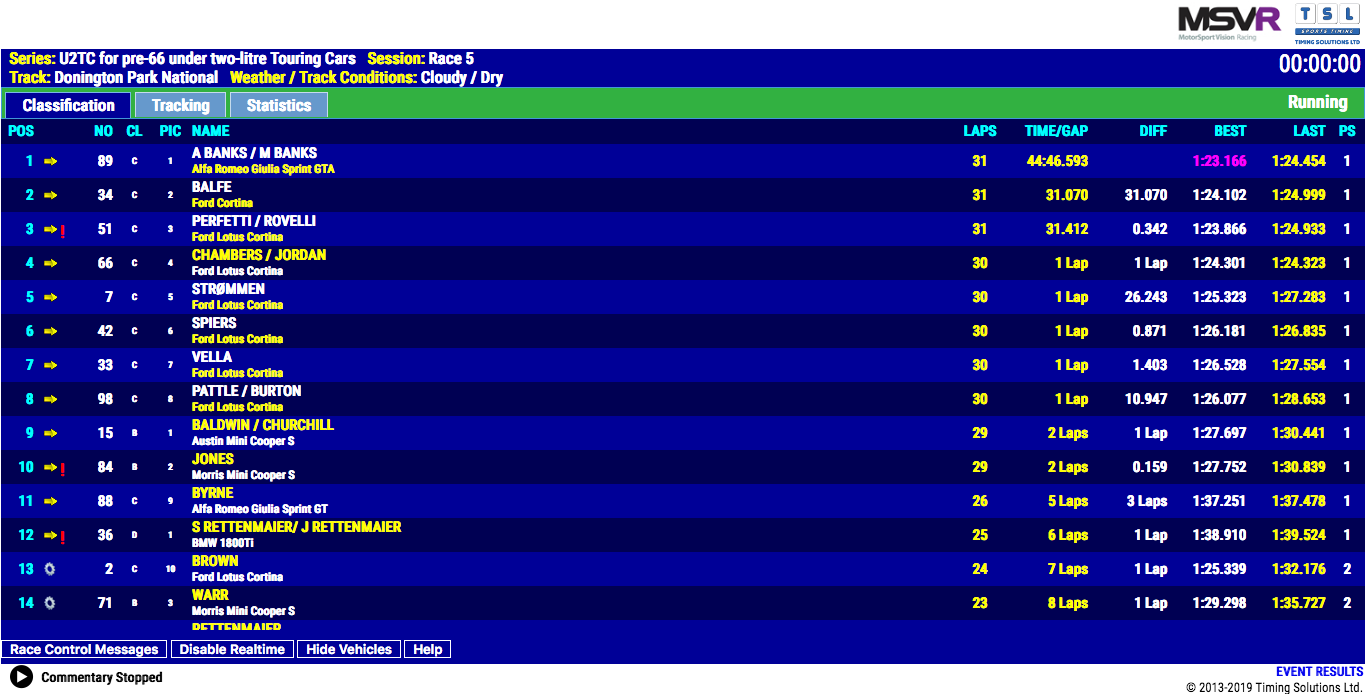

'screenshot_Classification.png'

In [48]:
#should perhap have a wait here to just make sure evrything is loaded...
#Or perhaps better, a guard at end of previous cell
#
setPageTab(browser, 'Classification')

In [49]:
import time

xpath = '//*[@id="ResultsTableContainer"]'


#This should really be while not finished
while True:
    #Grab the timing screen
    el = browser.find_element_by_xpath(xpath)
    
    #Parse out the data
    df = pd.read_html( el.get_attribute('innerHTML'))[0].dropna(axis=1,how='all')
    #Tidy up the column names
    df.rename(columns={'Time/Gap':'Gap',
                       'Unnamed: 1':'Penalties'}, inplace=True)
    #Upsert the date
    #DB[_table].upsert_all(df.to_dict(orient='records'))
    #insert the date
    DB[_table].insert_all(df.to_dict(orient='records'))
    print('.',end='')
    time.sleep(15)
    
#TO DO - also record time stamp; and maybe in another table, flag status vs timestamp
#so then we can easily retrieve eg approximate safety car periods etc

...............

KeyboardInterrupt: 

I need to rethink the logic...

We need to grab the timing screen just after a car has lapped; at this point, the sector times will be the sector times from the previous lap.


Thinking this through: we need to sample at a rate less than the min sector time to grab all the sector time data. To capture the gap data, we need to sample between the last car on the lead lap and the leader (this makes sure we have a full column of times). Or we just forgo the Gap as noise? What's important is that we get the lap and sector times? Which is the first sampling of the row for a particular (vehicle number / lap) key pair.

When the leader laps, the other cars show `1 Lap` in the `Gap` column. When one of those car laps, we want to capture it. The unique key is the car number, and the lap number. When a car completes a lap, all the sector times are in place, lap counter increments and so does the last lap time. So we don't need an upsert. We need to add the new PK key and ignore any other updates.

To get sector times, we only need to sample with a period less than the minimum sector time. To grab the correct gap to leader time, the sample for a driver on a given lap has to be made while they are on the lead lap. The diff should always be correct?

So need to check the df to see if the PK is already taken, and if it is, don't add the row. Alternatively, we can define the SQLite database table to ignore any attempt to add a row for which the PK is already taken.

In [54]:
dbname='testlive4.db'

#!rm $dbname
conn = sqlite3.connect(dbname, timeout=10)

q="SELECT * FROM tsl_timing_classification;"
pd.read_sql(q,conn)

,Pos,Penalties,No,Cl,PIC,Name,Laps,TimeGap,Diff,Best,Last,PS,S1,V1,S2,V2,S3,VF
0,2,Penalties +0 seconds +0 position +0 lap +0...,5,None,None,FOLCH-RUSINOL (AUB) Ford GT40,7,1 Lap,1 Lap,1:24.861,1:24.861,NaN,25.882,129.3,35.931,154.9,None,NaN
1,3,Penalties +0 seconds +0 position +0 lap +0...,4,None,None,DAVIES (MET) Ford GT40,7,1 Lap,1.026,1:25.084,1:25.084,NaN,25.922,132.3,35.274,154.9,None,NaN
2,4,Penalties +0 seconds +0 position +0 lap +0...,14,None,None,HUGENHOLTZ (MET) Ford GT40,7,1 Lap,0.455,1:25.164,1:25.164,NaN,25.819,129.5,35.715,148.7,None,NaN
3,5,Penalties +0 seconds +0 position +0 lap +0...,25,None,None,HIBBERD (TOR) Lotus-Ford 23B,7,1 Lap,0.661,1:25.205,1:25.205,NaN,26.222,137.5,35.884,135.2,None,NaN
4,6,Penalties +0 seconds +0 position +0 lap +0...,7,None,None,GOODWIN (DAR) Lotus-Ford 23B,7,1 Lap,1.129,1:23.598,1:23.598,NaN,26.053,137.2,35.167,139.8,None,NaN
5,7,Penalties +0 seconds +0 position +0 lap +0...,2,None,None,FENNELL (AUB) Lotus-Ford 23B,7,1 Lap,8.605,1:27.045,1:27.045,NaN,26.967,132.6,36.316,134.2,None,NaN
6,24,Penalties +0 seconds +0 position +0 lap +0...,6,None,None,HEACOCK (AUB) Penske Zerex Special,6,2 Laps,1 Lap,1:37.151,1:38.007,NaN,30.112,116.5,41.275,126.6,None,NaN
7,8,Penalties +0 seconds +0 position +0 lap +0...,3,None,None,OWEN (TOR) Elva-BMW Mk7S,7,1 Lap,1 Lap,1:28.108,1:28.411,NaN,26.872,115.7,37.271,142.1,None,NaN
8,9,Penalties +0 seconds +0 position +0 lap +0...,36,None,None,BRUSCHNIK (TOR) Porsche 910,7,1 Lap,1.174,1:28.110,1:28.497,NaN,28.919,124.2,36.924,135.8,None,NaN
9,10,Penalties +0 seconds +0 position +0 lap +0...,23,None,None,KUBOTA (TOR) Lotus-Ford 23B,7,1 Lap,0.253,1:27.596,1:28.201,NaN,27.473,121.3,36.6,139.2,None,NaN


The times are reported as strings, which would could cast to intervals (the pandas 

In [55]:
#Preferred time format
def formatTime(t):
    return float("%.3f" % t)

# Accept times in the form of hh:mm:ss.ss or mm:ss.ss
# Return the equivalent number of seconds and milliseconds
def getTime(ts, ms=False):
    ts=str(ts)
    t=ts.strip()
    if t=='': return pd.to_datetime('')
    if ts=='P': return None
    if 'LAP'.lower() in ts.lower():
        ts=str(1000*int(ts.split(' ')[0]))
    t=ts.split(':')
    if len(t)==3:
        tm=60*int(t[0])+60*int(t[1])+float(t[2])
    elif len(t)==2:
        tm=60*int(t[0])+float(t[1])
    else:
        tm=float(pd.to_numeric(t[0], errors='coerce'))
    if ms:
        #We can't cast a NaN as an int
        return float(1000*formatTime(tm))
    return float(formatTime(tm))

In [56]:
df['LastInS']=df['Last'].apply(getTime)
df['BestInS']=df['Best'].apply(getTime)
df.head()

,Pos,Penalties,No,Cl,PIC,Name,Laps,Gap,Diff,Best,Last,PS,LastInS,BestInS
0,1,Penalties +0 seconds +0 position +0 lap +0...,89,C,1,A BANKS / M BANKS Alfa Romeo Giulia Sprint GTA,34,49:00.035,NaN,1:23.166,1:24.344,1,84.344,83.166
1,2,Penalties +0 seconds +0 position +0 lap +0...,34,C,2,BALFE Ford Cortina,33,1 Lap,1 Lap,1:24.102,1:26.031,1,86.031,84.102
2,3,Penalties +0.001 seconds +0 position +0 lap...,51,C,3,PERFETTI / ROVELLI Ford Lotus Cortina,33,1 Lap,0.708,1:23.866,1:26.536,1,86.536,83.866
3,4,Penalties +0 seconds +0 position +0 lap +0...,66,C,4,CHAMBERS / JORDAN Ford Lotus Cortina,33,1 Lap,37.809,1:23.732,1:23.732,1,83.732,83.732
4,5,Penalties +0 seconds +0 position +0 lap +0...,7,C,5,STRØMMEN Ford Lotus Cortina,33,1 Lap,33.926,1:25.323,1:27.257,1,87.257,85.323


We can then easily save the dataframe to a CSV file:

In [57]:
df.to_csv('test1.csv')

#### Saving the Data to a Database
We can also save the data into a SQLite database.

There are several ways of doing this, of varying degrees of casulaness. The simplest way might be to create a separte table for each race (that is, each series and session combination) but that would explode the number of tables.

If we want to use fewer tables, then we need to know which series/session timing screens are alike (that is, have the same format / columns). It may be that all the sreens are the same, or it may be that practice, qualifying and race screens show different information. We would also need to check whether each series records the same columns in the timing screen if we are to have a single table for "race" data for example.

Also note that we would need to add some columns to the table if we are including data from mutliple series and/or sessions in the same table to identify which series/session any particular row in the table refers to.

In [58]:
import sqlite3
conn = sqlite3.connect("test.db")
df.to_sql('test1', con=conn, index=False, if_exists='replace')

We can now query the data:

In [59]:
sql = 'SELECT * FROM test1 LIMIT 3'
pd.read_sql_query(sql, conn)

,Pos,Penalties,No,Cl,PIC,Name,Laps,Gap,Diff,Best,Last,PS,LastInS,BestInS
0,1,Penalties +0 seconds +0 position +0 lap +0...,89,C,1,A BANKS / M BANKS Alfa Romeo Giulia Sprint GTA,34,49:00.035,None,1:23.166,1:24.344,1,84.344,83.166
1,2,Penalties +0 seconds +0 position +0 lap +0...,34,C,2,BALFE Ford Cortina,33,1 Lap,1 Lap,1:24.102,1:26.031,1,86.031,84.102
2,3,Penalties +0.001 seconds +0 position +0 lap...,51,C,3,PERFETTI / ROVELLI Ford Lotus Cortina,33,1 Lap,0.708,1:23.866,1:26.536,1,86.536,83.866


Note that we might also want to think about defining the database columns more formally if we know the structure of the timing screen data we want to record.

## Viewing Other Tabs

We can also grab data from tabs other than the *Classification* tab:

screenshot saved to screenshot_Statistics.png


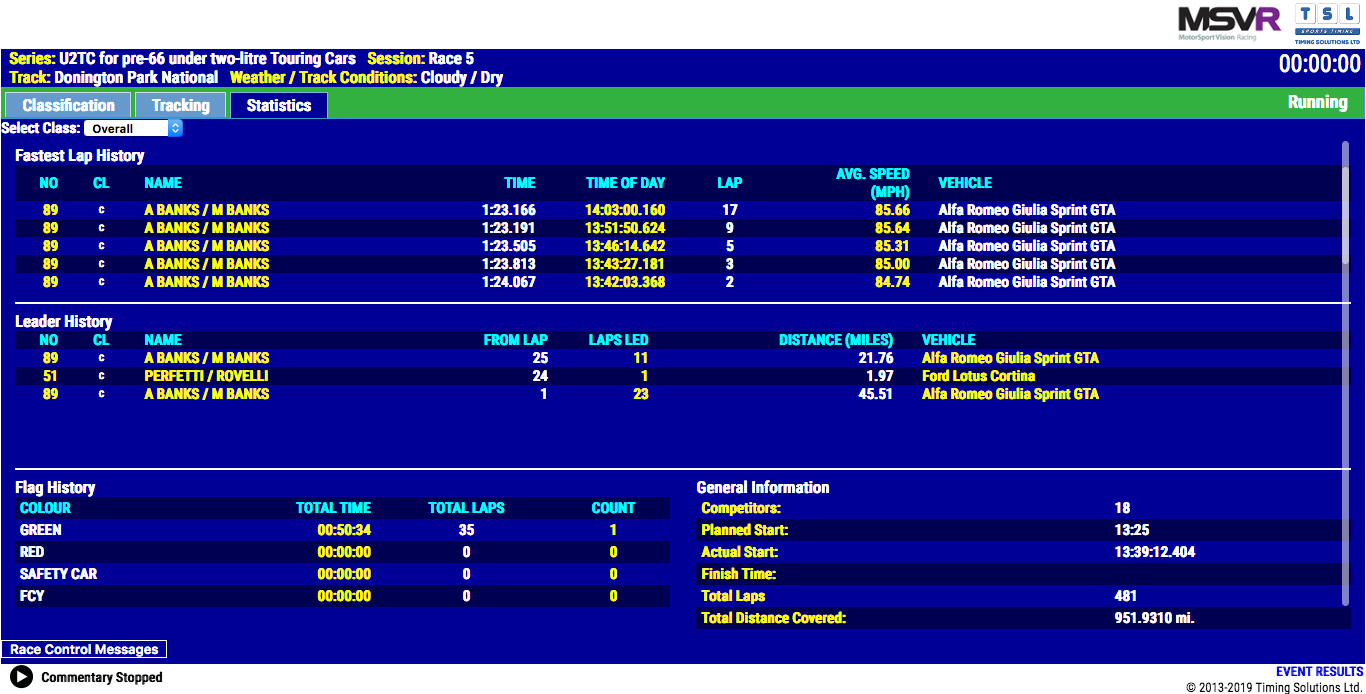

'screenshot_Statistics.png'

In [60]:
browser = initBrowser(url)
setPageTab(browser, 'Statistics')

In [61]:
#get statistics table
#//*[@id="StatsTableContainer"]/div[3]/div[2]/table
xpath = '//*[@id="StatsTableContainer"]/div[3]/div[2]/table'
el = browser.find_element_by_xpath(xpath)
el.text
#'Competitors: 30\nPlanned Start: 15:10\nActual Start: 15:25:00.510\nFinish Time:\nTotal Laps 107\nTotal Distance Covered: 129.2501 mi.\nTrack Length: 1.2079 mi.'

'Competitors: 18\nPlanned Start: 13:25\nActual Start: 13:39:12.404\nFinish Time:\nTotal Laps 481\nTotal Distance Covered: 951.9310 mi.\nTrack Length: 1.9790 mi.'

In [62]:
pd.read_html( '<table>{}</table>'.format(el.get_attribute('innerHTML')))[0].dropna(axis=1,how='all')

,0,1
0,Competitors:,18
1,Planned Start:,13:25
2,Actual Start:,13:39:12.404
3,Finish Time:,NaN
4,Total Laps,481
5,Total Distance Covered:,951.9310 mi.
6,Track Length:,1.9790 mi.


In [63]:
#Flags table
xpath = '//*[@id="StatsTableContainer"]/div[3]/div[1]/table[1]'
el = browser.find_element_by_xpath(xpath)
el.text
#'COLOUR TOTAL TIME TOTAL LAPS COUNT\nGREEN 00:05:45 5 1\nRED 00:00:29 0 1\nSAFETY CAR 00:00:00 0 0\nFCY 00:00:00 0 0'

'COLOUR TOTAL TIME TOTAL LAPS COUNT\nGREEN 00:50:36 35 1\nRED 00:00:00 0 0\nSAFETY CAR 00:00:00 0 0\nFCY 00:00:00 0 0'

In [64]:
pd.read_html( '<table>{}</table>'.format(el.get_attribute('innerHTML')))[0].dropna(axis=1,how='all')

,COLOUR,TOTAL TIME,TOTAL LAPS,COUNT
0,GREEN,00:50:37,35,1
1,RED,00:00:00,0,0
2,SAFETY CAR,00:00:00,0,0
3,FCY,00:00:00,0,0


In [65]:
#fastest laps
fastlap_path ='//*[@id="fastestLapTable"]'
el = browser.find_element_by_xpath(fastlap_path)
el.text
#'NO CL NAME TIME TIME OF DAY LAP AVG. SPEED (MPH) VEHICLE\n15\nM\nOLIPHANT * 54.140 15:29:02.984 4 80.32 BMW 330i M Sport\n116\nM\nSUTTON 54.685 15:28:24.626 3 79.52 Subaru Levorg\n25\nM\nNEAL 54.983 15:28:18.112 3 79.08 Honda Civic Type R\n1\nM\nTURKINGTON 55.127 15:28:07.375 3 78.88 BMW 330i M Sport\n303\nI\nSIMPSON 55.228 15:27:58.303 2 78.73 Honda CIvic Type R\n80\nM\nINGRAM 55.449 15:27:17.128 2 78.42 Toyota Corolla\n77\nM\nJORDAN 56.278 15:27:14.039 2 77.27 BMW 330i M Sport\n15\nM\nOLIPHANT * 56.858 15:27:13.242 2 76.48 BMW 330i M Sport\n1\nM\nTURKINGTON 57.049 15:27:12.248 2 76.22 BMW 330i M Sport'

'NO CL NAME TIME TIME OF DAY LAP AVG. SPEED (MPH) VEHICLE\n89\nC\nA BANKS / M BANKS 1:23.166 14:03:00.160 17 85.66 Alfa Romeo Giulia Sprint GTA\n89\nC\nA BANKS / M BANKS 1:23.191 13:51:50.624 9 85.64 Alfa Romeo Giulia Sprint GTA\n89\nC\nA BANKS / M BANKS 1:23.505 13:46:14.642 5 85.31 Alfa Romeo Giulia Sprint GTA\n89\nC\nA BANKS / M BANKS 1:23.813 13:43:27.181 3 85.00 Alfa Romeo Giulia Sprint GTA\n89\nC\nA BANKS / M BANKS 1:24.067 13:42:03.368 2 84.74 Alfa Romeo Giulia Sprint GTA\n89\nC\nA BANKS / M BANKS 1:26.900 13:40:39.300 1 81.98 Alfa Romeo Giulia Sprint GTA'

In [66]:
pd.read_html( '<table>{}</table>'.format(el.get_attribute('innerHTML')))[0].dropna(axis=1,how='all')

,NO,CL,NAME,TIME,TIME OF DAY,LAP,AVG. SPEED (MPH),VEHICLE
0,89,C,A BANKS / M BANKS,1:23.166,14:03:00.160,17,85.66,Alfa Romeo Giulia Sprint GTA
1,89,C,A BANKS / M BANKS,1:23.191,13:51:50.624,9,85.64,Alfa Romeo Giulia Sprint GTA
2,89,C,A BANKS / M BANKS,1:23.505,13:46:14.642,5,85.31,Alfa Romeo Giulia Sprint GTA
3,89,C,A BANKS / M BANKS,1:23.813,13:43:27.181,3,85.00,Alfa Romeo Giulia Sprint GTA
4,89,C,A BANKS / M BANKS,1:24.067,13:42:03.368,2,84.74,Alfa Romeo Giulia Sprint GTA
5,89,C,A BANKS / M BANKS,1:26.900,13:40:39.300,1,81.98,Alfa Romeo Giulia Sprint GTA


In [67]:
#leader history
leaderHistory_path = '//*[@id="leaderHistory"]/div/table'
el = browser.find_element_by_xpath(leaderHistory_path)
el.text
#NO NAME FROM LAP LAPS LED DISTANCE (MILES) VEHICLE\n19\nHENSHALL 6 1 1.64 Caterham 310R\n77\nSAWYER 4 2 3.28 Caterham 310R\n25\nMCCORMACK 2 2 3.28 Caterham 310R\n11\nPERRY 1 1 1.64 Caterham 310R

'NO CL NAME FROM LAP LAPS LED DISTANCE (MILES) VEHICLE\n89\nC\nA BANKS / M BANKS 25 11 21.76 Alfa Romeo Giulia Sprint GTA\n51\nC\nPERFETTI / ROVELLI 24 1 1.97 Ford Lotus Cortina\n89\nC\nA BANKS / M BANKS 1 23 45.51 Alfa Romeo Giulia Sprint GTA'

In [68]:
pd.read_html( '<table>{}</table>'.format(el.get_attribute('innerHTML')))[0].dropna(axis=1,how='all')

,NO,CL,NAME,FROM LAP,LAPS LED,DISTANCE (MILES),VEHICLE
0,89,C,A BANKS / M BANKS,25,11,21.76,Alfa Romeo Giulia Sprint GTA
1,51,C,PERFETTI / ROVELLI,24,1,1.97,Ford Lotus Cortina
2,89,C,A BANKS / M BANKS,1,23,45.51,Alfa Romeo Giulia Sprint GTA


Create a function to grab statistcs tab data.

In [69]:
#TO DO
def statisticsData(browser):
    
    setPageTab(browser, 'Statistics')
    
    #flags
    xpath = '//*[@id="StatsTableContainer"]/div[3]/div[1]/table[1]'
    el = browser.find_element_by_xpath(xpath)
    df_flags = pd.read_html( '<table>{}</table>'.format(el.get_attribute('innerHTML')))[0].dropna(axis=1,how='all')
    
    #fastest laps
    fastlap_path ='//*[@id="fastestLapTable"]'
    el = browser.find_element_by_xpath(fastlap_path)
    df_fastest = pd.read_html( '<table>{}</table>'.format(el.get_attribute('innerHTML')))[0].dropna(axis=1,how='all')
    
    #leader history
    leaderHistory_path = '//*[@id="leaderHistory"]/div/table'
    el = browser.find_element_by_xpath(leaderHistory_path)
    df_leaderhistory = pd.read_html( '<table>{}</table>'.format(el.get_attribute('innerHTML')))[0].dropna(axis=1,how='all')

    return df_flags, df_fastest, df_leaderhistory


screenshot saved to screenshot_Statistics.png


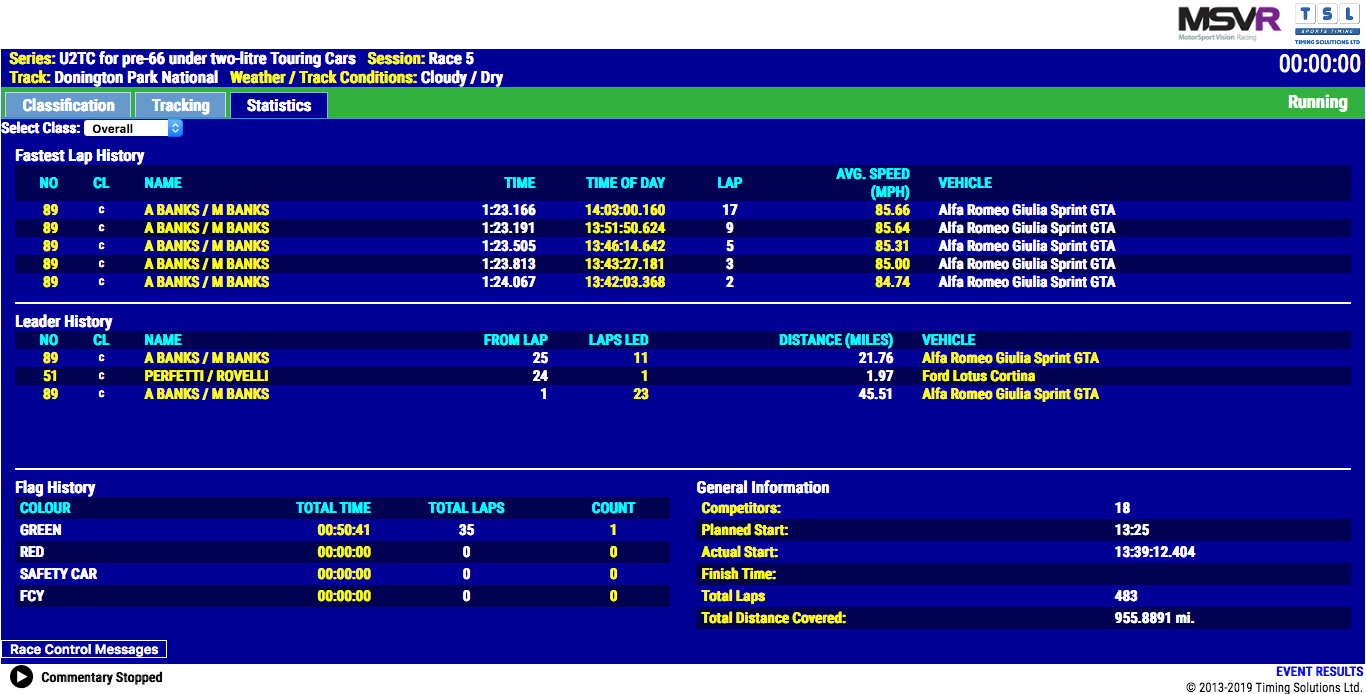

(       COLOUR TOTAL TIME  TOTAL LAPS  COUNT
 0       GREEN   00:50:41          35      1
 1         RED   00:00:00           0      0
 2  SAFETY CAR   00:00:00           0      0
 3         FCY   00:00:00           0      0,
    NO CL               NAME      TIME   TIME OF DAY  LAP  AVG. SPEED (MPH)  \
 0  89  C  A BANKS / M BANKS  1:23.166  14:03:00.160   17             85.66   
 1  89  C  A BANKS / M BANKS  1:23.191  13:51:50.624    9             85.64   
 2  89  C  A BANKS / M BANKS  1:23.505  13:46:14.642    5             85.31   
 3  89  C  A BANKS / M BANKS  1:23.813  13:43:27.181    3             85.00   
 4  89  C  A BANKS / M BANKS  1:24.067  13:42:03.368    2             84.74   
 5  89  C  A BANKS / M BANKS  1:26.900  13:40:39.300    1             81.98   
 
                         VEHICLE  
 0  Alfa Romeo Giulia Sprint GTA  
 1  Alfa Romeo Giulia Sprint GTA  
 2  Alfa Romeo Giulia Sprint GTA  
 3  Alfa Romeo Giulia Sprint GTA  
 4  Alfa Romeo Giulia Sprint GTA  
 5  Alfa 

In [70]:
statisticsData(browser)

screenshot saved to U2TC for pre-66 under two-litre Touring Cars_Race 5.png


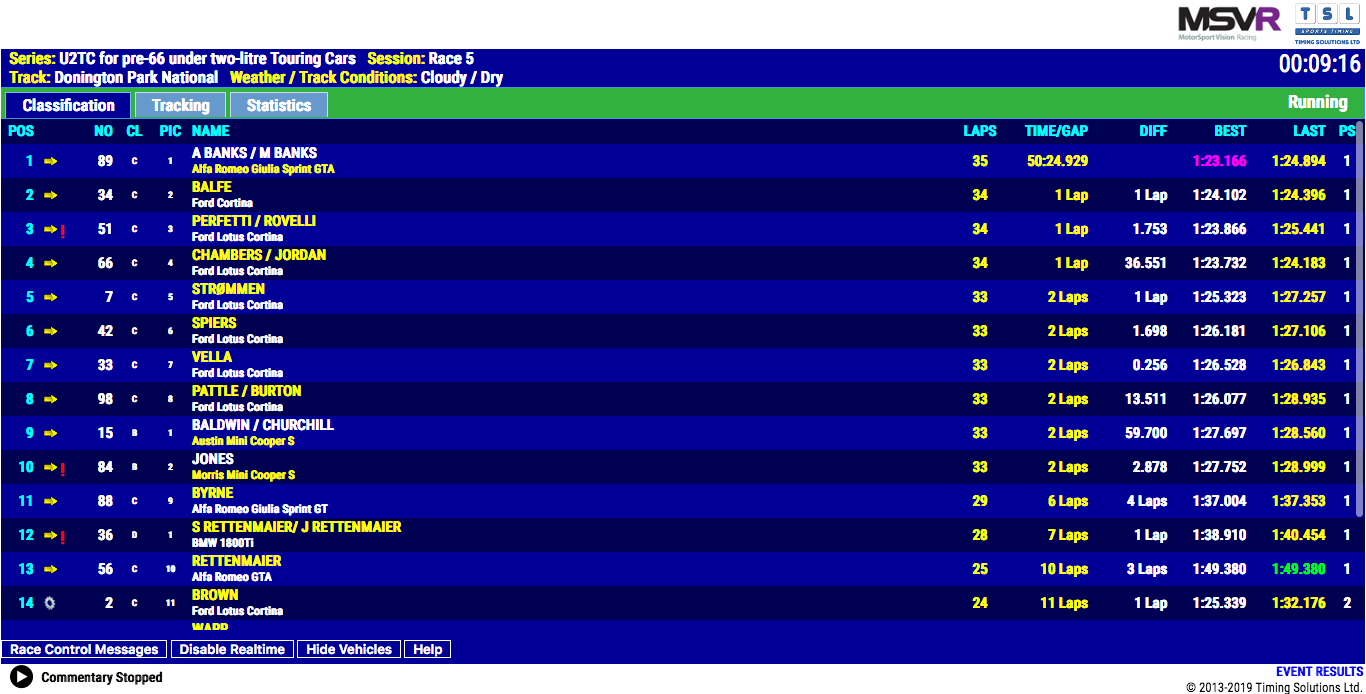

'U2TC for pre-66 under two-litre Touring Cars_Race 5.png'

In [71]:
#get file name
fn = '{}_{}.png'.format(series, session )

setPageTab(browser, 'Classification', fn)

In [72]:
#Doesn't work?
trackDisplayName_path ='//*[@id="weatherConditions"]/span[2]'
trackDisplayName = text_value_from_xpath(browser, trackDisplayName_path )
trackDisplayName

'Donington Park National'

In [73]:
#Doesn't work?
weatherConditions_xpath = '//*[@id="weatherConditions"]/span[4]'
weatherConditions = text_value_from_xpath(browser, weatherConditions_xpath )
weatherConditions

'Cloudy'

In [74]:
#Doesn't work?
trackConditions_xpath = '//*[@id="weatherConditions"] '
trackConditions = text_value_from_xpath(browser, trackConditions_xpath )
trackConditions

'Track: Donington Park National Weather / Track Conditions: Cloudy / Dry'

## Automated Grab

The aim here is to grab a copy of the screen classification when the race has finished.

(How is finished flagged? Eg if the clock has reached zero do cars get to finish the lap they are on? At what point does "FINISHED" appear?)

*(If we want to run browsers over several timing screens, eg for different meetings on the same day, it may be worth looking to something like https://github.com/micahscopes/nbmultitask so we could launch several watchers, one per timing screen, in separate, non-blocking processes.)*

In [75]:
#flag status is something like"

#FINISHED
#RUNNING
#RED FLAG
#Scheduled Start: 16.55
#Safety Car

Set up the database:

In [76]:
def initDb(dbname='test.db'):
    
    #TO DO: change to py fn
    #!rm $dbname
    
    conn = sqlite3.connect(dbname, timeout=10)

    #Setup database tables
    c = conn.cursor()
    #c.executescript(classification_table)


    DB = Database(conn)
    #_table = 'tsl_timing_classification'
    #
    return c, DB

In [123]:
import hashlib

#The _table_hash will persist in the function
def timingScreenToDB(browser, DB, _table='testTable', _table_hash={'hash':''}, resettable=True):#, period=15):

    #check we're on the right tab
    setPageTab(browser, 'Classification', preview=False)
    
    
    xpath = '//*[@id="ResultsTableContainer"]'

    #Grab the timing screen
    el = browser.find_element_by_xpath(xpath)

    #Parse out the data
    df = pd.read_html( el.get_attribute('innerHTML'))[0].dropna(axis=1,how='all')
                     
    #Get a hash of the table; if it's the same as last time, refresh the page just this once...
    _table_hash_new =  hashlib.md5(df.to_html().encode('utf-8')).hexdigest()
    if _table_hash['hash'] == _table_hash_new and resettable:
        print('hmmm... stuck page? Try a refresh...')
        browser.refresh()
        timingScreenToDB(browser, DB, _table, False)
    _table_hash['hash'] == _table_hash_new
                     
    #Tidy up the column names
    df.rename(columns={'Time/Gap':'Gap',
                       'Unnamed: 1':'Penalties'}, inplace=True)
    
    #Get the icon status
    df['icons'] = getPosIcon(browser)['icons']
    
    #Add time in seconds for best and last
    #Getting a key not found error from a fresh start for some reason, so guard against that
    if 'Last' in df:
        df['LastInS']=df['Last'].apply(getTime)
    if 'Best' in df:
        df['BestInS']=df['Best'].apply(getTime)
    
    #Get the flag status
    flag = text_value_from_xpath(browser, flag_path )
    df['Flag'] = flag
        
    #Upsert the date
    #DB[_table].upsert_all(df.to_dict(orient='records'))
    #insert the data - this assumes the insert conflict ignore definition on the table
    DB[_table].insert_all(df.to_dict(orient='records'))
    #print('.',end='')
    #time.sleep(period)

    #outfile='tmp.png'
    #browser.save_screenshot( outfile )
    #Can we get this to just update the same image?
    #display(Image(outfile))
    
    #TO DO - also record time stamp; and maybe in another table, flag status vs timestamp
    #so then we can easily retrieve eg approximate safety car periods etc

The timing screen goes into a blank state when waiting for a new race. We may need to refresh it every so often when waiting for a new race to start. Do this with: `browser.refresh()`

Note that if we do this we need to set a wait for the page to load before we try to work on it.

In [78]:
#Immortalise statistics in DB

## TO DO - BROKEN - I think sqlite_utils is messing up on colnames again
# A workaround would to be have a column name cleaner and redefine the table definitions

def initStatsDBTables(c, _table):
    c.executescript(fastest_laps_table.format(_table=_table))
    c.executescript(flags_table.format(_table=_table))
    c.executescript(leaderhistory_table.format(_table=_table))


def statisticsScreenToDB(browser, DB, _table='test_stats'):
    df_flags, df_fastest, df_leaderhistory = statisticsData(browser)
    
    DB['{}_flags'.format(_table)].insert_all(df_flags.to_dict(orient='records'))
    DB['{}_fastest'.format(_table)].insert_all(df_fastest.to_dict(orient='records'))
    DB['{}__leader_history'.format(_table)].insert_all(df_leaderhistory.to_dict(orient='records'))


screenshot saved to screenshot_Statistics.png


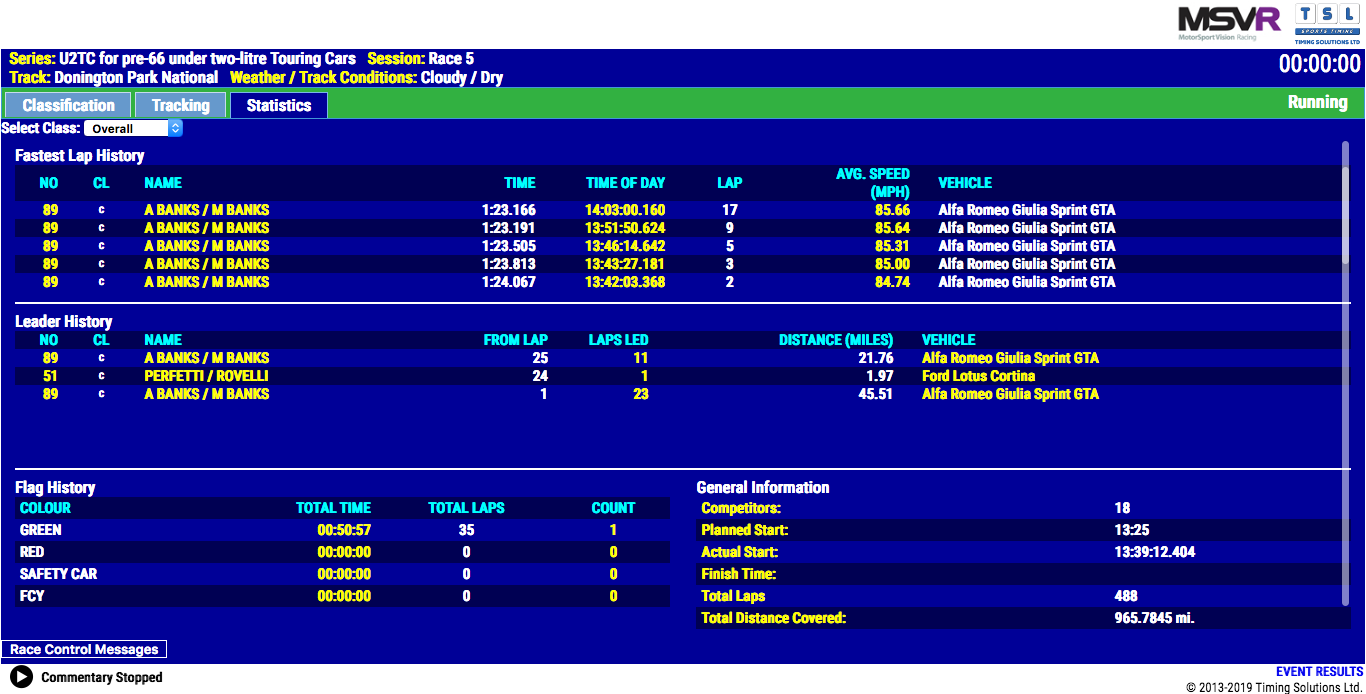

(       COLOUR TOTAL TIME  TOTAL LAPS  COUNT
 0       GREEN   00:50:57          35      1
 1         RED   00:00:00           0      0
 2  SAFETY CAR   00:00:00           0      0
 3         FCY   00:00:00           0      0,
    NO CL               NAME      TIME   TIME OF DAY  LAP  AVG. SPEED (MPH)  \
 0  89  C  A BANKS / M BANKS  1:23.166  14:03:00.160   17             85.66   
 1  89  C  A BANKS / M BANKS  1:23.191  13:51:50.624    9             85.64   
 2  89  C  A BANKS / M BANKS  1:23.505  13:46:14.642    5             85.31   
 3  89  C  A BANKS / M BANKS  1:23.813  13:43:27.181    3             85.00   
 4  89  C  A BANKS / M BANKS  1:24.067  13:42:03.368    2             84.74   
 5  89  C  A BANKS / M BANKS  1:26.900  13:40:39.300    1             81.98   
 
                         VEHICLE  
 0  Alfa Romeo Giulia Sprint GTA  
 1  Alfa Romeo Giulia Sprint GTA  
 2  Alfa Romeo Giulia Sprint GTA  
 3  Alfa Romeo Giulia Sprint GTA  
 4  Alfa Romeo Giulia Sprint GTA  
 5  Alfa 

In [79]:
browser=initBrowser(url)

df_flags, df_fastest, df_leaderhistory = statisticsData(browser)
df_flags, df_fastest, df_leaderhistory

In [80]:
DB['{}_flags'.format(_table)].insert_all(df_flags.to_dict(orient='records'))

<Table tsl_timing_classification_flags>

screenshot saved to screenshot_Statistics.png


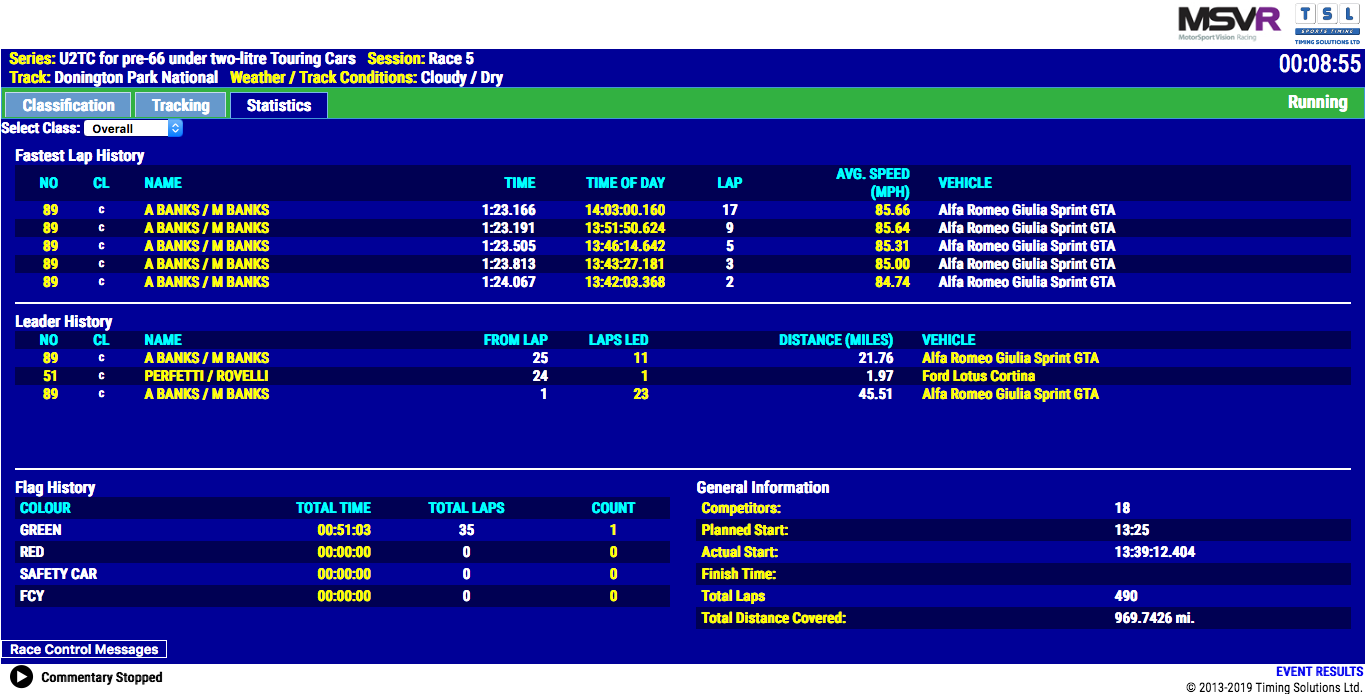

In [81]:
statisticsScreenToDB(browser, DB, _table)

In [82]:
#initStatsDBTables(c, _table)

In [83]:
df_fastest.to_dict(orient='records')

[{'NO': 89,
  'CL': 'C',
  'NAME': 'A BANKS / M BANKS',
  'TIME': '1:23.166',
  'TIME OF DAY': '14:03:00.160',
  'LAP': 17,
  'AVG. SPEED (MPH)': 85.66,
  'VEHICLE': 'Alfa Romeo Giulia Sprint GTA'},
 {'NO': 89,
  'CL': 'C',
  'NAME': 'A BANKS / M BANKS',
  'TIME': '1:23.191',
  'TIME OF DAY': '13:51:50.624',
  'LAP': 9,
  'AVG. SPEED (MPH)': 85.64,
  'VEHICLE': 'Alfa Romeo Giulia Sprint GTA'},
 {'NO': 89,
  'CL': 'C',
  'NAME': 'A BANKS / M BANKS',
  'TIME': '1:23.505',
  'TIME OF DAY': '13:46:14.642',
  'LAP': 5,
  'AVG. SPEED (MPH)': 85.31,
  'VEHICLE': 'Alfa Romeo Giulia Sprint GTA'},
 {'NO': 89,
  'CL': 'C',
  'NAME': 'A BANKS / M BANKS',
  'TIME': '1:23.813',
  'TIME OF DAY': '13:43:27.181',
  'LAP': 3,
  'AVG. SPEED (MPH)': 85.0,
  'VEHICLE': 'Alfa Romeo Giulia Sprint GTA'},
 {'NO': 89,
  'CL': 'C',
  'NAME': 'A BANKS / M BANKS',
  'TIME': '1:24.067',
  'TIME OF DAY': '13:42:03.368',
  'LAP': 2,
  'AVG. SPEED (MPH)': 84.74,
  'VEHICLE': 'Alfa Romeo Giulia Sprint GTA'},
 {'NO': 89

screenshot saved to screenshot_Statistics.png


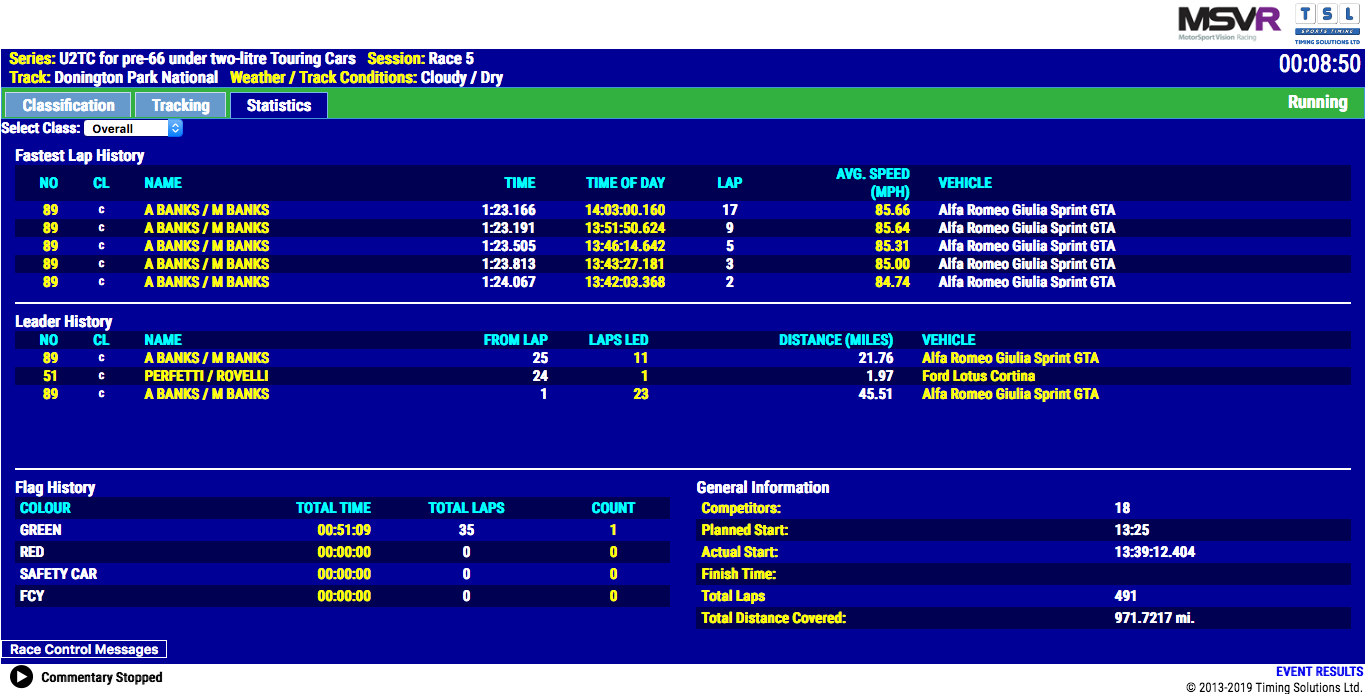

[{'COLOUR': 'GREEN', 'TOTAL TIME': '00:51:09', 'TOTAL LAPS': 35, 'COUNT': 1},
 {'COLOUR': 'RED', 'TOTAL TIME': '00:00:00', 'TOTAL LAPS': 0, 'COUNT': 0},
 {'COLOUR': 'SAFETY CAR',
  'TOTAL TIME': '00:00:00',
  'TOTAL LAPS': 0,
  'COUNT': 0},
 {'COLOUR': 'FCY', 'TOTAL TIME': '00:00:00', 'TOTAL LAPS': 0, 'COUNT': 0}]

In [84]:
df_flags, df_fastest, df_leaderhistory = statisticsData(browser)
df_flags.to_dict(orient='records')

screenshot saved to screenshot_Statistics.png


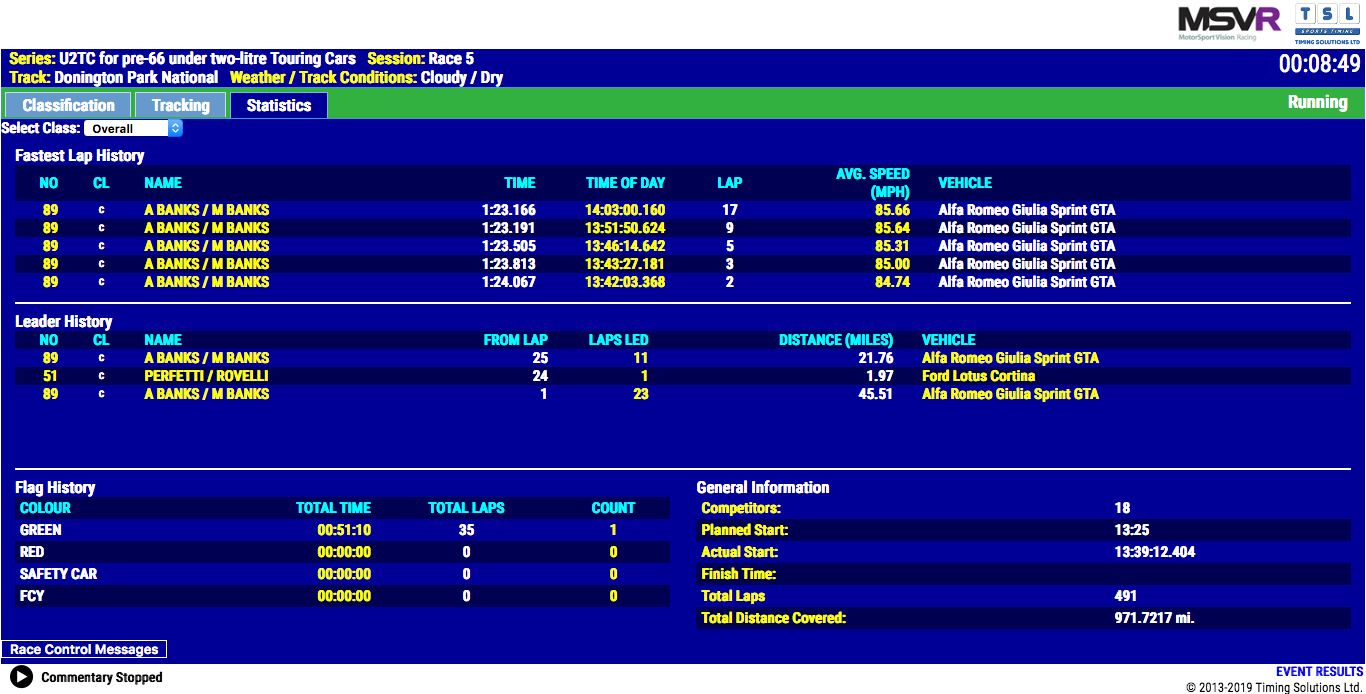

In [85]:
statisticsScreenToDB(browser, DB)

In [70]:
url_brscc = 'https://livetiming.tsl-timing.com/191431'
url_btcc='https://livetiming.tsl-timing.com/191403' #btcc april 6

In [71]:
browser.get(url_btcc)

In [72]:
url='https://livetiming.tsl-timing.com/191521'
#url='https://livetiming.tsl-timing.com/191531'


In [73]:
getInfo(browser)

{'series': '', 'session': '', 'tablename': '_'}

In [74]:
_table= getInfo(browser)['tablename']
c.executescript(classification_table.format(_table=_table))

If there is a long wait to the next race, the timing screen reports a `Scheduled Start` time. We can compare the current time to the scheduled start time, and if there is a long wait, we could go to sleep for a bit...

So how can we work out how long to wait?

In [86]:
#What's the time now?
from datetime import datetime
n = datetime.now()
n

datetime.datetime(2019, 5, 4, 14, 30, 41, 711627)

In [87]:
#What's the schedule start time?
from dateutil import parser
s = parser.parse("{} {} {} {}".format(n.year, n.month, n.day, '15:50'))
s

datetime.datetime(2019, 5, 4, 15, 50)

In [88]:
#What's the difference?
(s-n).seconds

4758

In [90]:
n = datetime.now()
s = parser.parse("{} {} {} {}".format(n.year, n.month, n.day, '17:40'))
(s-n).days

0

In [136]:
def waitTimeToStart(tts, delay=120):
    ''' Calculate a sensible sleep time given the cirrent time and the scheduled start time.
        The delay gives the time before the scheduled start time we're happy to sleep until.
    '''
    n = datetime.now()
    s = parser.parse("{} {} {} {}".format(n.year, n.month, n.day, tts))
    tts = (s-n)
    
    #If the time is after the scehduled start time, wait a minute...
    #Seems we don't get negative seconds?
    if tts.days < 0: 
        return 60
    #If the time is within the prescribed delay period, no need for an extra wait
    elif tts.seconds<delay:
        return tts.seconds
    else:
        return (s-n).seconds - delay

In [132]:
def emailReport(info):
    '''Holding pattern - defined below...'''
    print('We could do emailing here....')
    display(Image(info['finalscreen']))

In [130]:
c, DB = initDb('may4test5.db')

screenshot saved to screenshot_Classification.png


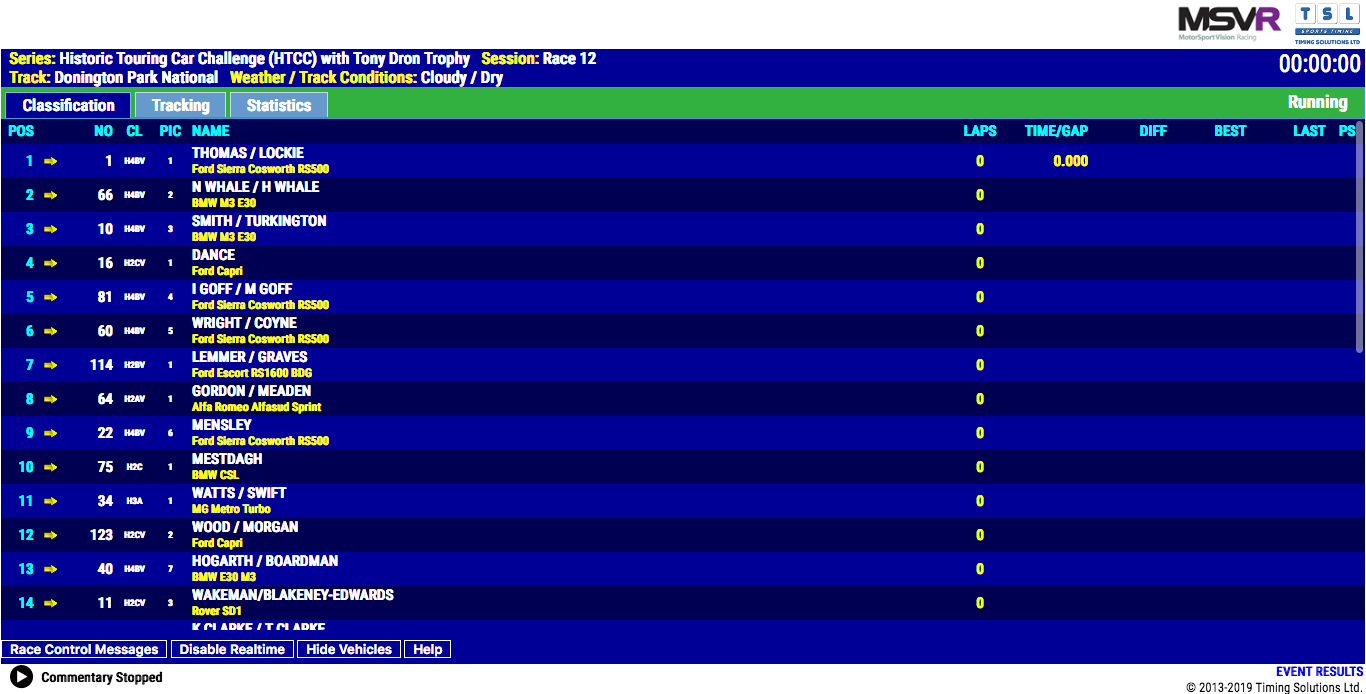

Creating table HISTORIC_TOURING_CAR_CHALLENGE_HTCC_WITH_TONY_DRON_TROPHY_R_12 if it doesn't already exist
letsgoracing...
screenshot saved to screenshot_Classification.png
.Running 00:00:00screenshot saved to screenshot_Classification.png
.Running 00:56:01screenshot saved to screenshot_Classification.png
.Running 00:54:46screenshot saved to screenshot_Classification.png
.Safety Car 00:53:30screenshot saved to screenshot_Classification.png
.Safety Car 00:52:15screenshot saved to screenshot_Classification.png
.Safety Car 00:50:59screenshot saved to screenshot_Classification.png
.Safety Car 00:49:43screenshot saved to screenshot_Classification.png
.Safety Car 00:48:28screenshot saved to screenshot_Classification.png
.Safety Car 00:47:11screenshot saved to screenshot_Classification.png
.Safety Car 00:45:56screenshot saved to screenshot_Classification.png
.Running 00:44:40screenshot saved to screenshot_Classification.png
.Running 00:43:25screenshot saved to screenshot_Classification.png
.Ru

In [ ]:
import time

#Start to build up the logic

period=75
period_lap = 95 #This is the time we'll after we record the race as finished before declaring a result
#This means we declare a result at most period+period_lap after we first see FINISHED flag

finishedwait=60
refresh_before_scheduled_start = 120

send_email = True #Do we want to send email
sent_email = False #Have we sent an email for this race

#If we are in a race
browser = initBrowser(url)



showpreview=True
while True:
    
    prevSessionTime = None #heuristic to try to spot if we are stuck
    #If we are stuck, reload the browser
    shoved=False #part of the keep it running heuristic
    
    sent_email = False
    
    #Reload the browser after each race
    browser = initBrowser(url)
    info =  getInfo(browser)
    
    #Need to check we have a valid table name
    #If not, do a delay and then continue back to repeat the loop
    _table = getInfo(browser)['tablename']
    
    if not _table or _table=='':
        print('Nothing seems to be on the timing screen...Wait a couple of minutes...')
        wait(120)
        continue
        
    previewed = showpreview
    setPageTab(browser, 'Classification', preview=showpreview)
    
    #Start doing setup for a particular race here

    flag = text_value_from_xpath(browser, flag_path )
    if flag.upper()=='FINISHED':
        print('Still on screen from previous race')
        time.sleep(finishedwait)
        showpreview=False
        continue
    
    #If the scheduled start is some time away, wait until a few mins before the scheduled start
    #Or should we keep polling...
    #What happens over lunch? The previous table chekc should catch things there?
    
    #eg: Scheduled Start: 15.50 20:00
    if flag.startswith('Scheduled Start'):
        waitfor = waitTimeToStart(flag.replace('Scheduled Start','').split()[1],refresh_before_scheduled_start) 
        print('Race start {}; now {} so sleeping for {}s'.format(flag,datetime.now(),waitfor))
        time.sleep( waitfor )
        showpreview=False
        continue
        
    #Try to limit how often we display the screen
    #If we showed it on the way in, no need to show it now.
    #If we didn't show it on the way in, preview it here.
    showpreview=True
    if not previewed:
        setPageTab(browser, 'Classification', preview=showpreview)
    
    print("Creating table {} if it doesn't already exist".format(_table))
    c.executescript(classification_table.format(_table=_table))

    race_on = True if flag!='Finished' else False
    
    awaiting_result=True
    letsgoracing = True
    while race_on and awaiting_result:
        
        #If for some reason the process goes to sleep,
        # ensure we don't add data to the wrong table when we wake up...
        if _table != getInfo(browser)['tablename']:
            print('hmmm, did I nod off there?')
            break
            
        if letsgoracing:
            print('letsgoracing...')
            letsgoracing = False
            
        #Better to use some heuristics here eg based on time left in sessiontime
        #Only issue there is if a race is red flagged so is race clock/sessionTime?
        #So maybe try to grab close race start time, ish, and sessionTime at that point
        #and generate a heuristic about earliest time race is expected to finish?
        #For some reason, the flag doesn't seem to update in the browser properly?
        flag = text_value_from_xpath(browser, flag_path )
        
        timingScreenToDB(browser, DB, _table)
        print('.',end='')

        sessionTime = text_value_from_xpath(browser, sessionTime_path )
        print(flag, sessionTime, end='')
        
        
        #Hack for now
        statsdone=False    
        while flag.upper()=='FINISHED':
            #TO DO - Grab statistics tables and save to DB
            #We need to wait and do a final check - wait for time approx one lap
            #Get worst best lap time and use that? 
            time.sleep(period_lap)
            #Then need to get guaranteed final times and stats - but make sure screen is still there..
            #Need to guard that we do not do this if we have moved on to another race...
            #Note that this field may take some time to populate after a browser refresh?
            flag = text_value_from_xpath(browser, flag_path )

            if flag.upper()=='FINISHED':
                timingScreenToDB(browser, DB, _table)
                if not statsdone:
                    initStatsDBTables(c, _table)
                    statisticsScreenToDB(browser, DB, _table)
                    statsdone=True
                #keep refreshing
                browser = initBrowser(url)
                final_screen = setPageTab(browser,'Classification', preview=False, link=True)
                #TO DO - a lot of the following is dependent on things later in the notebook...
                if send_email and not sent_email:
                    #server = smtplib.SMTP_SSL("smtp.gmail.com", port, context=context)
                    #server.login(sender_email, sender_password)

                    #send_to = [] if  not 'send_to' in locals() else locals()['send_to']
                    #info =  getInfo(browser)
                    #send_from = sender_email
                    #subject = 'Autogenerated bits for {} - {}'.format(info['series'], info['session'])
                    #text = "Some automatically generated bits from {} - {}. Check the attachments...".format(info['series'], info['session'])
                    #outfiles = [final_screen, get_best_csv(_table),get_laps_csv(_table), get_boxplot(_table)]
                    #try:
                    #    print('mailing...')
                    #    send_mail(server, send_from, send_to, subject, text, files=outfiles)
                    #except:
                    #    print('mail send failed')
                    #html email needs work?
                    #send_mail_html(server, sender_email, receiver_email,
                    #               subject, text, htmltext, files=[final_screen])
                    emailinfo = {'finalscreen':final_screen}
                    emailReport(emailinfo)
                    sent_email = True
            print('Session should have completely finished...')
            awaiting_result = False
            #Also grab final classification table as a complete, separate thing
            #?need to create table?
            #timingScreenToDB(browser, DB, '{}_final_timing_screen'.format(_table))
            #setPageTab(browser, 'Statistics')
            #statisticsScreenToDB(browser, DB, '{}_final_statistics'.format(_table))

        #carry on waiting
        time.sleep(period)

        #Sometimes things seem to get stuck on the timing screen, so give it a shove
        sessionTime = text_value_from_xpath(browser, sessionTime_path )
        if prevSessionTime and sessionTime==prevSessionTime:
            if shoved:
                #Let's try and go back to the start...
                awaiting_result = False
            print('shove..')
            prevSessionTime = sessionTime
            #browser = initBrowser(url)
            browser.refresh()
            shoved = True

fn = '{}_{}.png'.format(series, session )


#Don't need to get the URL? Just dump the screenshot instead?
#Browser is already good and if meeting is busy we may not be able to get a new connection onto timing screen?
#setPageTab(browser, 'Classification', fn)

browser.save_screenshot( fn )

In [ ]:
def emailReport(info):
    server = smtplib.SMTP_SSL("smtp.gmail.com", port, context=context)
    server.login(sender_email, sender_password)

    send_to = [] if  not 'send_to' in locals() else locals()['send_to']

    subject = 'Autogenerated bits for {} - {}'.format(info['series'], info['session'])
    text = "Some automatically generated bits from {} - {}. Check the attachments...".format(info['series'], info['session'])
    outfiles = [final_screen, get_best_csv(_table),get_laps_csv(_table), get_boxplot(_table)]
    print('mailing...')
    
    send_mail(server, send_from, send_to, subject, text, files=outfiles)
    
    #print('failed...')
    #html email needs work?
    #send_mail_html(server, sender_email, receiver_email,
    #               subject, text, htmltext, files=[final_screen])

emailReport(info)

In [ ]:
send_from

In [383]:
def get_best_csv(_table):
    sql = 'SELECT No, Name, Cl, MIN(Best) FROM {} WHERE Best IS NOT NULL GROUP BY No ORDER BY Cl, MIN(Best)'.format(_table)
    outdf = pd.read_sql_query(sql, conn)
    
    #TO DO - is this in the table anyway?
    outdf['BestInS']=outdf['MIN(Best)'].apply(getTime)
    
    fn='{}_best.csv'.format(_table)
    outdf.to_csv(fn,index=False)
    return fn

fn = get_best_csv(_table)
!head {fn}

No,Name,Cl,MIN(Best),BestInS
474,EVANS  Mini Libre 1399,Libre,1:36.118,96.118
500,DAVIS  Mini Libre 1380,Libre,1:36.631,96.631
113,HARVEY  Mini Libre 1380,Libre,1:37.374,97.374
616,COOPER  Mini Libre 1380,Libre,1:37.824,97.824
177,CREWES  Mini Libre 1380,Libre,1:42.494,102.494
48,DEEGAN  Mini Miglia 1275,Mig,1:33.705,93.705
1,SMITH  Mini Miglia 1293,Mig,1:33.789,93.789
11,ASTIN  Mini Miglia 1293,Mig,1:33.865,93.865
83,PEACOCK  Mini Miglia 1293,Mig,1:34.171,94.171


In [351]:
sql = 'SELECT * FROM {} LIMIT 2'.format(_table)
pd.read_sql_query(sql, conn)

,Pos,Penalties,No,Cl,PIC,Name,Laps,Gap,Diff,Best,Last,PS,S1,V1,S2,V2,S3,VF
0,1,Penalties +0 seconds +0 position +0 lap +0...,1,Mig,1,SMITH Mini Miglia 1293,0,0.0,None,None,None,None,None,None,None,None,None,None
1,2,Penalties +0 seconds +0 position +0 lap +0...,80,Mig,2,THOMPSON Mini Miglia 1300,0,None,None,None,None,None,None,None,None,None,None,None


In [384]:
def get_laps_df(_table):
    sql = 'SELECT No, Name, Cl, Laps, Last FROM {} ORDER BY No'.format(_table)
    outdf = pd.read_sql_query(sql, conn)
    
    #TO DO - is this in the table anyway?
    outdf['LastInS']=outdf['Last'].apply(getTime)
    
    return outdf

def get_laps_csv(_table):
    outdf = get_laps_df(_table)
    fn = '{}_laps.csv'.format(_table)
    outdf.to_csv(fn,index=False)
    return fn

fn = get_laps_csv(_table)
!head {fn}

No,Name,Cl,Laps,Last,LastInS
1,SMITH  Mini Miglia 1293,Mig,0,,
1,SMITH  Mini Miglia 1293,Mig,1,1:40.948,100.948
1,SMITH  Mini Miglia 1293,Mig,2,1:35.646,95.646
1,SMITH  Mini Miglia 1293,Mig,3,1:34.637,94.637
1,SMITH  Mini Miglia 1293,Mig,4,1:35.517,95.517
1,SMITH  Mini Miglia 1293,Mig,5,1:34.875,94.875
1,SMITH  Mini Miglia 1293,Mig,6,1:34.541,94.541
1,SMITH  Mini Miglia 1293,Mig,7,1:34.748,94.748
1,SMITH  Mini Miglia 1293,Mig,8,1:35.080,95.08


In [ ]:
outdf

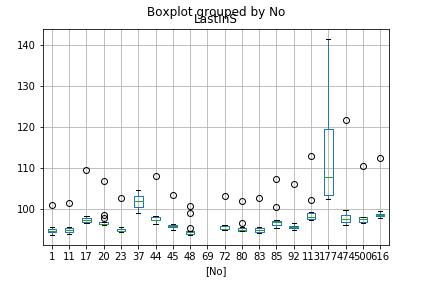

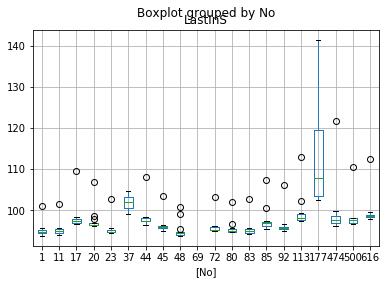

In [390]:
from IPython.display import clear_output

def get_boxplot(_table, fn=None):
    outdf = get_laps_df(_table)
    p = outdf[['No','LastInS']].boxplot(by='No')
        
    fig = p.get_figure()
    fn = '{}.png'.format(_table) if fn is None else fn

    fig.savefig(fn)
    return fn

#matplotlib will autodisplay the image
fn = get_boxplot(_table)

#Display from file
Image(fn)

In [361]:
#!pip3 install rpy2
#%load_ext rpy2.ipython
#COuld we integrae R code in the notebook for plotting?

# Emailing the screenshot

Having grabbed the screenshot, we might now want to email it to somebody.

We can do that with the `smtplib` package if we have the details of an SMTP server we can connect to.

For example, if you have a GMail account:

In [97]:
import smtplib, ssl, getpass
from IPython.display import clear_output



In [ ]:

sender_email = input("Type your Email address and press enter: ")
sender_password =  getpass.getpass()


receiver_email = input("Email address for test send: ")#"user@example.com"  # Enter receiver address
message = """\
Subject: Test

Test message from code..."""


smtp_server="smtp.gmail.com"
port = 465  # For SSL
# Create a secure SSL context
context = ssl.create_default_context()

with smtplib.SMTP_SSL(smtp_server, port, context=context) as server:
    server.login(sender_email, sender_password)
    server.sendmail(sender_email, receiver_email, message)
    
#Clear the output so we don't share emails in saved notebook
clear_output()

In [321]:
receiver_email = input("Email address for test send: ")#"user@example.com"  # Enter receiver address
with smtplib.SMTP_SSL("smtp.gmail.com", port, context=context) as server:
    server.login(sender_email, sender_password)
    server.sendmail(sender_email, receiver_email, message)

#Clear the output so we don't share emails in saved notebook
clear_output()

In [ ]:
def getMailBlurb(browser, subject=None, text=None):
    subject = ''
    
    text="""Here's some autograbbed data from the end of the race...
    
    It's all automated.
    
    There may be attachments..
    """

In [311]:
subject='Test email attachment'
text = """some text
Over several

lines"""


Let's go defensive and check we have at least one valid email to send to...

In [106]:
#https://www.scottbrady91.com/Email-Verification/Python-Email-Verification-Script
import re

def checkEmails(addressesToVerify):
    ''' Tests one or more email addresses. Returns list of emails that parse. '''
    addressesToVerify = addressesToVerify if isinstance(addressesToVerify, list) else [addressesToVerify]
    
    regex = '^[_a-z0-9-]+(\.[_a-z0-9-]+)*@[a-z0-9-]+(\.[a-z0-9-]+)*(\.[a-z]{2,4})$'

    validEmailAddresses = []
    for addressToVerify in addressesToVerify:
        if re.match( regex, addressToVerify):
            validEmailAddresses.append(re.match( regex, addressToVerify).group())

    #Return uniques
    return list(set(validEmailAddresses))


#checkEmails(['a.bkexample.com','a@bkexample.com','a@bkexample.com'])
#We could go further and check it's a valid email
#eg https://www.scottbrady91.com/Email-Verification/Python-Email-Verification-Script
#or other validation packages

In [108]:
#https://stackoverflow.com/a/3363254/454773
from os.path import basename
from email.mime.application import MIMEApplication
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.utils import COMMASPACE, formatdate

def send_mail(server, send_from, send_to, subject='Test subject email', text='Test message text', files=None):
    if not send_from:
        print('No sender?')
        return
    
    send_to = checkEmails(send_to)
        
    assert isinstance(send_to, list)
    #assert isinstance(files, list)

    msg = MIMEMultipart()
    #The from can be different to the sender, which was used to login to mailgun
    msg['From'] = send_from
    msg['To'] = COMMASPACE.join(send_to)
    msg['Date'] = formatdate(localtime=True)
    msg['Subject'] = subject

    msg.attach(MIMEText(text))

    for f in files or []:
        with open(f, "rb") as fo:
            part = MIMEApplication(
                fo.read(),
                Name=basename(f)
            )
        # After the file is closed
        part['Content-Disposition'] = 'attachment; filename="%s"' % basename(f)
        print('attach part {}'.format(part['Content-Disposition']))
        msg.attach(part)



    #smtp = smtplib.SMTP(server)
    smtp = server
    smtp.sendmail(send_from, send_to, msg.as_string())
    smtp.close()


    
#server = smtplib.SMTP_SSL("smtp.gmail.com", port, context=context)
#server.login(sender_email, sender_password)
#send_mail(server, sender_email, [receiver_email], subject, text, files=[outfile])

Sending with image inline as HTML email:

In [109]:
cid = 0 #A unique id count for the image

#We'd probably need to rethink this for multiple images...
htmltext=''''<html><body><h1>Timing screen</h1>\n<div><img src="cid:{cid}"></div>\n</body></html>'''.format(cid=cid)

In [110]:
import uuid
from email.mime.base import MIMEBase
from email import encoders

#ish via https://www.code-learner.com/python-send-html-image-and-attachment-email-example/
def add_image(msg, img, iid=0):
    uniqueId = '{}-{}-{}'.format(img.split('/')[-1], datetime.now().strftime('%Y%m%d%H%M%S'), uuid.uuid4())
    
    with open(outfile, 'rb') as f:
        # set attachment mime and file name, the image type is png
        mime = MIMEBase('image', 'png', filename=img)
        # add required header data:
        mime.add_header('Content-Disposition', 'attachment', filename=img)
        mime.add_header('X-Attachment-Id', str(iid))
        mime.add_header('Content-ID', '<{}>'.format(iid))
        # read attachment file content into the MIMEBase object
        mime.set_payload(f.read())
        # encode with base64
        encoders.encode_base64(mime)
        # add MIMEBase object to MIMEMultipart object
        msg.attach(mime)
    
def send_mail_html(server, send_from, send_to, subject, text, htmltext, files=None):
    
    if not send_from:
        print('No sender?')
        return
    
    send_to = checkEmails(send_to)
    
    if not send_to:
        print('No valid email addresses to send to.')
        return
    
    assert isinstance(send_to, list)
    assert isinstance(files, list)

    msg = MIMEMultipart('alternative')
    #the from can be different to the sender, which was used to login to mailgun
    msg['From'] = send_from
    msg['To'] = COMMASPACE.join(send_to)
    msg['Date'] = formatdate(localtime=True)
    msg['Subject'] = subject

    msg.attach(MIMEText(text))

    fid=0
    for f in files or []:
        add_image(msg, f, fid)
        fid += 1
        
    #It would make sense to add the images somehow into the htmltext
    #Maybe htmltext needs templating?
    msg.attach(MIMEText(htmltext, 'html', 'utf-8'))


    #smtp = smtplib.SMTP(server)
    smtp = server
    smtp.sendmail(send_from, send_to, msg.as_string())
    smtp.close()
    


In [ ]:
#mailgun setup

In [347]:
#This will guard that we have a receiver_email variable
receiver_email = [] if  not 'receiver_email' in locals() else locals()['receiver_email']

server = smtplib.SMTP_SSL("smtp.gmail.com", port, context=context)
server.login(sender_email, sender_password)
send_mail_html(server, sender_email, receiver_email, subject, text, htmltext, files=[outfile])

No valid email addresses to send to.


In [124]:
#Not ssl?

#use tls
server = smtplib.SMTP(smtp_server, port)
# identify ourselves to smtp gmail client
server.ehlo()
# secure our email with tls encryption
server.starttls()
# re-identify ourselves as an encrypted connection
server.ehlo()

server.login(sender_email, sender_password)
send_mail(server, sender_email, receiver_email, subject='new test')

#server.quit()




SMTPServerDisconnected: please run connect() first

## TO DO

On the emailer:

- tidy it up so there's a reasonable way of adding multiple images to HTML email and getting the IDs right...

On the screengrabber:

- keep checking the page, parsing it to look for when a session is complete, then send an email of the final classification etc.

*I'm not sure if this would require reloading the page or whether the socket connection to the live timing server works and selenium can just keep rechecking for when a particular id takes a `FINISHED` value?*